# EX3 - Advanced ML

---
<br>

### Name and ID:
Student 1: Ron Darmon
<br>
Student 2: Roei Arpaly

---

## Part 0: Choose pretrained image classification model and images to be explained

### 1) Choose a pretrained image classification model *f* to be explained.
The model will be used as a black box. You only need to be able to classify new images using
the model. You can use the following resource: https://pytorch.org/vision/stable/models.html

In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pretrained model
class_labels = ResNet50_Weights.IMAGENET1K_V2.meta.get('categories')
transform = ResNet50_Weights.IMAGENET1K_V2.transforms().to(DEVICE)
resnet = resnet50(weights="IMAGENET1K_V2").to(DEVICE)
resnet.eval();

In [ ]:
import io
import requests
from PIL import Image


def fetch_image(url):
    response = requests.get(url)
    return Image.open(io.BytesIO(response.content))

### 2) Select 3 images to be classified and explained

In [ ]:
def image_preprocess(image):
    return transform(image).unsqueeze(0)

In [ ]:
import numpy as np


def predict_image(image):
    # Get the predicted probabilities and class labels of top 3 classes
    with torch.no_grad():
        output = resnet(image)
        proba, indices = output.topk(k=3)
        top_classes = np.asarray(class_labels)[indices]
    return top_classes.squeeze(), proba.numpy().squeeze(), indices.numpy().squeeze()

In [ ]:
image_1 = fetch_image('https://cdn-p300.americantowns.com/img/article/ct-dog-parks-1.jpg')
image_2 = fetch_image('https://www.webbox.co.uk/wp-content/uploads/2019/04/shutterstock_1095001973.jpg')
image_3 = fetch_image('https://qph.cf2.quoracdn.net/main-qimg-9f9cc4b5edb8d1c298ca1b792aa63b89')
image_4 = fetch_image('https://www.wired.com/images_blogs/underwire/images/2007/07/05/0102090491400.jpg')

## Part 1: Choose pretrained image classification model

### 3) Get the top 3 classes from the model

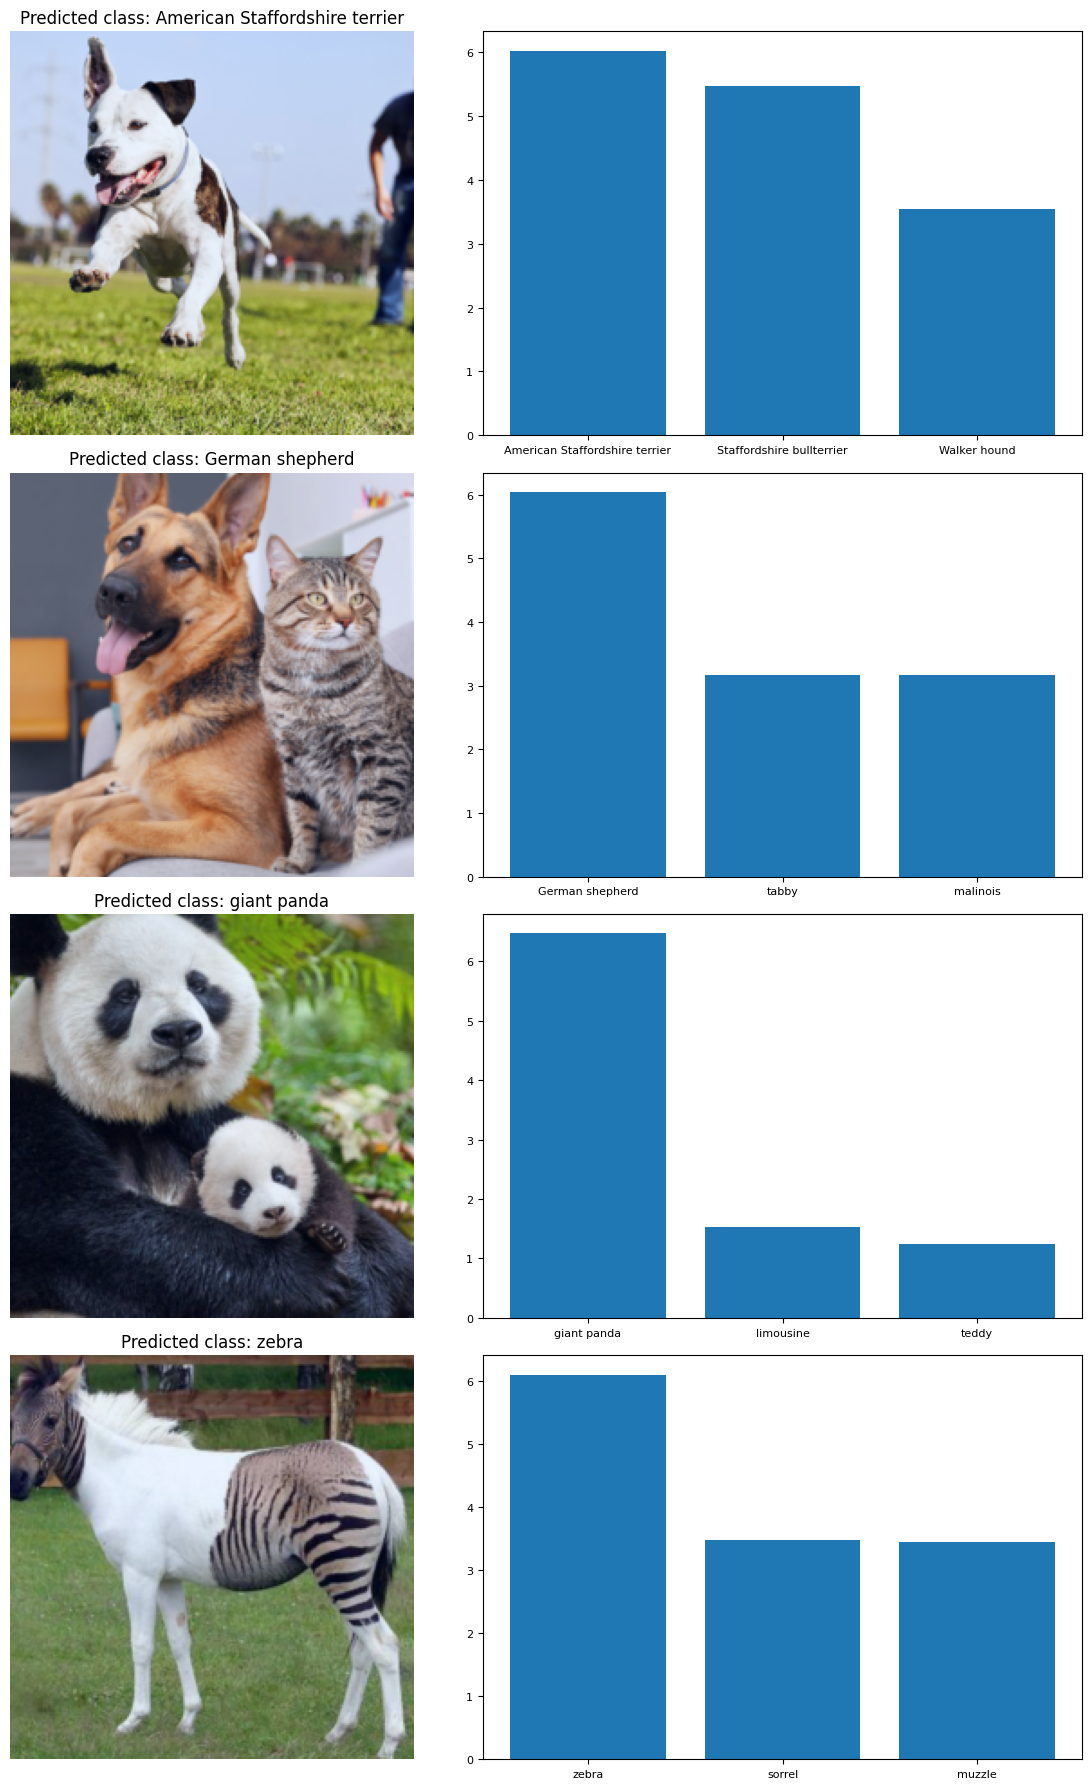

In [ ]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,18))

images_predictions = {}
for i, image in enumerate([image_1, image_2, image_3, image_4]):

    image_prep = image_preprocess(image)
    top_classes, proba, top_indices = predict_image(image_prep)
    images_predictions[i] = [top_classes, top_indices]

    # Unnormalize the image
    image_prep = image_prep.squeeze().permute(1, 2, 0)
    norm_image = (image_prep - image_prep.min()) / (image_prep.max() - image_prep.min())

    axes[i,0].imshow(norm_image)
    axes[i,0].set_title(f"Predicted class: {top_classes[0]}")
    axes[i,0].axis("off")
    axes[i,1].bar(x=top_classes, height=proba)
    axes[i,1].tick_params(axis='both', which='both', labelsize=8)

fig.tight_layout();

---

### 4) Interpretable (simplified) instances:
  * Generate interpretable versions of the images you chose by either splitting them to superpixels.
  * Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels x ∈ {0,1}

In [ ]:
from skimage.segmentation import slic, mark_boundaries
from sklearn.linear_model import Lasso
from sklearn.metrics import pairwise_distances


class LIME:

    """
    LIME - Local Interpretable Model-agnostic Explanations

    Parameters:
        model (object): The model used for prediction.

    Attributes:
        transformed_images (list): Transformed images after fitting.

    Methods:

        fit_transform(image, labels, n_samples=10, n_segments=20, alpha=0.05, sigma=1):
            Fit the LIME model and return the transformed images.

        _local_surrogate_lasso(image_prep, samples, label_scores, segments, alpha, pi):
                    Generate local surrogate models using Lasso regression.

        _calculate_proximity(segments, distinct_segments, samples, sigma):
            Calculate proximity weights based on pairwise distances.

        _perturb_image(sample, image, segments):
            Perturb the image by masking out selected segments.

    """

    def __init__(self, model):
        self.model = model

    def fit(self, image, labels, n_samples, n_segments, alpha, sigma):

        image_prep = image_preprocess(image)
        numpy_image = image_prep.squeeze(0).permute(2,1,0)  # (height, weight, channel)

        segments, samples, distinct_segments = self._generate_slic_segments(numpy_image, n_segments, n_samples)
        permuted_images = self._perturbed_images(numpy_image, segments, samples)
        scores = np.asarray([self._predict_score(image, labels) for image in permuted_images])
        pi = self._calculate_proximity(segments, distinct_segments, samples, sigma)

        self.transformed_images = [self._local_surrogate_lasso(
            image_prep, samples, scores[:, [i]], segments, alpha, pi) for i in range(len(labels))]

    def transform(self):
        return self.transformed_images

    def fit_transform(self, image, labels, n_samples=10, n_segments=20, alpha=0.05, sigma=1):
        self.fit(image, labels, n_samples, n_segments, alpha, sigma)
        return self.transform()

    def _generate_slic_segments(self, image, n_segments, n_samples):
        segments = slic(image, n_segments=n_segments) - 1
        distinct_segments = np.unique(segments).size
        samples = np.random.randint(2, size=(n_samples, distinct_segments))
        return segments, samples, distinct_segments

    def _perturbe_image(self, sample, image, segments):
        image = image.clone()
        mask = ~np.isin(segments, np.argwhere(sample))
        image[mask] = 0
        return image

    def _perturbed_images(self, image, segments, samples):
        images = np.apply_along_axis(self._perturbe_image, axis=1, arr=samples, image=image, segments=segments)
        return torch.tensor(images).permute(0,3,1,2)

    def _predict_score(self, image, labels):
        image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            scores = output[:, labels].numpy()
        return scores[0]

    def _calculate_proximity(self, segments, distinct_segments, samples, sigma):
        original_image_sample = np.ones(shape=(1, distinct_segments))
        distances = pairwise_distances(samples, original_image_sample, metric='euclidean').ravel()
        return np.sqrt(np.exp(-(distances**2) / sigma**2))

    def _local_surrogate_lasso(self, image_prep, samples, label_scores, segments, alpha, pi):
        lasso = Lasso(alpha=alpha)
        lasso.fit(samples, label_scores.flatten(), pi)
        top_superpixels = np.argwhere(lasso.coef_ > 0)
        mask = np.isin(segments, top_superpixels).T

        image_prep = image_prep.squeeze().permute(1, 2, 0)
        norm_image = (image_prep - image_prep.min()) / (image_prep.max() - image_prep.min())

        norm_image = norm_image.numpy()
        img_boundary = mark_boundaries(norm_image, mask, color=(0, 0, 0), outline_color=(0.8, 0.8, 0.8), )

        rgba = np.zeros(shape=norm_image.shape[:2])
        filter_image = np.dstack([norm_image, rgba])
        filter_image[~mask] = np.array([0, 0, 0, 0], dtype=float)
        filter_image[mask] = np.array([44/255, 160/255, 44/255, 0.5], dtype=float)

        return tuple([img_boundary, filter_image])

In [ ]:
lime = LIME(model=resnet)

---

### 5) For each class perform *f*:
* Local dataset generation
  * Generate a set of random perturbations of the interpretable instances by uniformly choosing which parts to include z' ∈ {0,1}!
  * For each generated interpretable instance, generate the corresponding image z and get its label *f(z)*
  * Calculate the similarity of the perturbed instance from the original image pi(z)
* Fit a local surrogate model g and generate explanations
  * Fit a linear model with locally weighted loss (using pi) and L! regularization on the generated dataset. Use K-Lasso for feature selection.
  * Find and present the set of important features (super-pixels/tiles) for the prediction *f(x)*

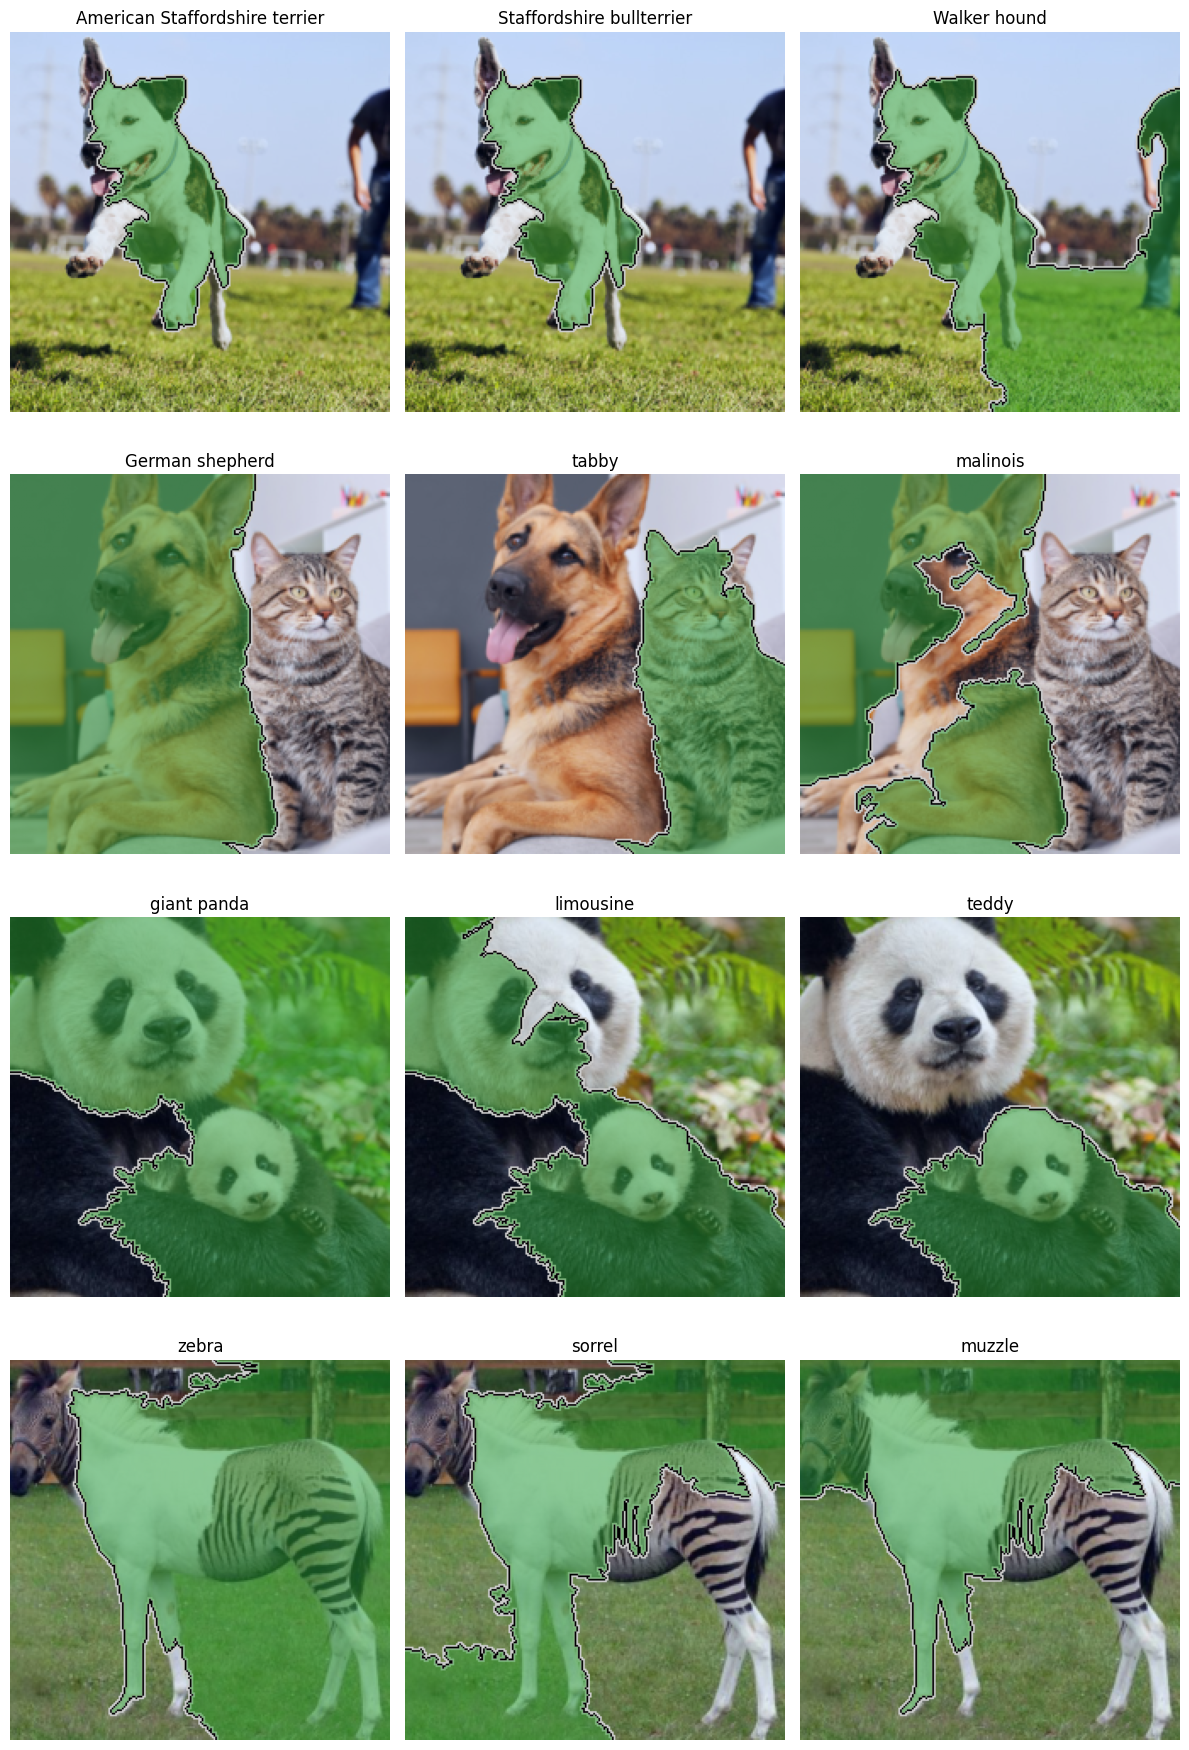

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 18))

for i, image in enumerate([image_1, image_2, image_3, image_4]):

    top_classes, top_indices = images_predictions[i]
    images = lime.fit_transform(image, top_indices, n_samples=50, n_segments=10, alpha=0.05,)

    for j, (label, index) in enumerate(zip(top_classes, top_indices)):
        axes[i, j].set_title(label)
        axes[i, j].imshow(images[j][0])
        axes[i, j].imshow(images[j][1])
        axes[i, j].axis("off")

fig.tight_layout();

---